In [25]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

import os
from sklearn.preprocessing import normalize

import tqdm as notebook_tqdm
#from tqdm.auto import tqdm
from torchmetrics import Accuracy

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger


from multiprocessing import cpu_count
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS

# Load the datasets
with open("Normal_120s.pkl", "rb") as f:
    normal_data = pd.read_pickle(f)

with open("Vibration_120s.pkl", "rb") as f:
    vibration_data = pd.read_pickle(f)


with open("RampUpDown_300s_Labelled.pkl", "rb") as f:
    rampupdown_data = pd.read_pickle(f)

with open("Friction_120s.pkl", "rb") as f:
    friction_data = pd.read_pickle(f)
    
with open("Data/Vibration_low_120s.pkl", "rb") as f:
    vibration_low_data = pd.read_pickle(f)

with open("Data/Friction_120s.pkl", "rb") as f:
    friction_low_data = pd.read_pickle(f)

%matplotlib inline

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [26]:
SEQUENCE_LENGTH = 400
BATCH_SIZE = 40
EPOCHS = 15
USE_CHECKPOINT = False
CHECKPOINT = "checkpoints/best-checkpoint-v59.ckpt"

N_CLASSES = 3

LR = 1e-3
N_HIDDEN_LAYERS = 256
N_LAYERS = 3
PRESISTANT_WORKERS= False
NUM_WORKERS = 0


#DATA_SETS = ["normal_data", "vibration_data", "rampupdown_data", "friction_data", "vibration_low_data", "friction_low_data"]
DATA_SETS = ["normal_data", "vibration_data", "friction_data"]#,"rampupdown_data", "vibration_low_data", "friction_low_data"]#
DATA_SETS_F = []
for val in DATA_SETS:
    if val == "rampupdown_data":
        DATA_SETS_F.append("rampUp_data")
        DATA_SETS_F.append("rampDown_data")
    else:
        DATA_SETS_F.append(val)


#Create result PATH
name = "LSTM_"
name += str(N_CLASSES) + "_"
for dataset in DATA_SETS:
    name += dataset + "_"
name += "seqLen" + str(SEQUENCE_LENGTH) + "_" + "BATCH" + str(BATCH_SIZE) + "_" + "EPOCHS" +  str(EPOCHS) + "_" + "NHidLay" + str(N_HIDDEN_LAYERS) + "_" + "NLay" + str(N_LAYERS) + "_" + "LR" + str(LR)
RESULT_PATH = "Results/LSTM - Classification/" + name


OVERWRITE_SEQUENCES = False
SEQUENCE_NAME = "SEQUENCES_"+ name +".pkl"

In [27]:
rampupdown_data

,time,ax_motor,ay_motor,az_motor,ax_bearing,ay_bearing,az_bearing,label,_value
0,2024-04-04 07:53:19.001000+00:00,-0.048706,-0.000916,1.010925,-0.013184,-0.017822,0.980896,bottom,59.0
1,2024-04-04 07:53:19.002000+00:00,-0.052490,-0.001892,1.011475,-0.025452,-0.016052,0.982056,bottom,59.0
2,2024-04-04 07:53:19.003000+00:00,-0.042969,-0.003418,1.011475,-0.022888,-0.013733,0.983276,bottom,59.0
3,2024-04-04 07:53:19.004000+00:00,-0.038879,-0.002258,1.010132,-0.011047,-0.011292,0.985901,bottom,59.0
4,2024-04-04 07:53:19.005000+00:00,-0.040588,-0.001282,1.008667,-0.008850,0.001709,0.988220,bottom,59.0
...,...,...,...,...,...,...,...,...,...
299995,2024-04-04 07:58:18.996000+00:00,-0.018433,0.014771,1.015015,-0.010925,0.013367,0.994263,rampdown,58.0
299996,2024-04-04 07:58:18.997000+00:00,-0.021118,0.020264,1.017273,-0.012878,0.004211,0.993896,rampdown,58.0
299997,2024-04-04 07:58:18.998000+00:00,-0.015930,0.027771,1.018188,0.000244,0.001526,0.993408,rampdown,58.0
299998,2024-04-04 07:58:18.999000+00:00,-0.021179,0.032654,1.017822,0.013428,0.003662,0.994385,rampdown,58.0


In [28]:
# Create Labels
normal_data['label'] = "normal"
vibration_data['label'] = "vibration"
for i, label in enumerate(rampupdown_data['label']):
    if label == "rampdown":
        rampupdown_data['label'].iloc[i] = "rampdown"
    elif label == "rampup":
        rampupdown_data['label'].iloc[i] = "rampup"
friction_data['label'] = "friction"
friction_low_data['label'] = "friction_low"
vibration_low_data['label'] = "vibration_low"


all_data = {
    "normal_data": normal_data,
    "vibration_data": vibration_data,
    "rampupdown_data": rampupdown_data,
    "friction_data": friction_data,
    "vibration_low_data": vibration_low_data,
    "friction_low_data": friction_low_data
}

# Find which datasets to include in data_to_use by looking at DATA_SETS
data_to_use = []
for dataset in DATA_SETS:
    if dataset in all_data:
        data_to_use.append(all_data[dataset])

data = pd.concat(data_to_use, ignore_index=True)



# Create Columns to be used for training
FEATURE_COLUMNS = data.columns[1:7]
print(FEATURE_COLUMNS)
data.head()

C:\Users\Anders\AppData\Local\Temp\ipykernel_141768\2106089859.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rampupdown_data['label'].iloc[i] = "rampup"
C:\Users\Anders\AppData\Local\Temp\ipykernel_141768\2106089859.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rampupdown_data['label'].iloc[i] = "rampdown"


Index(['ax_motor', 'ay_motor', 'az_motor', 'ax_bearing', 'ay_bearing',
       'az_bearing'],
      dtype='object')


,time,ax_motor,ay_motor,az_motor,ax_bearing,ay_bearing,az_bearing,label
0,2024-02-21 11:49:42.766000+00:00,-0.038330,0.109314,1.023132,-0.130005,0.055054,0.966431,normal
1,2024-02-21 11:49:42.767000+00:00,-0.004517,0.121460,1.025208,-0.002197,0.077881,0.969421,normal
2,2024-02-21 11:49:42.768000+00:00,-0.018738,0.124817,1.027283,0.033020,0.078430,0.973572,normal
3,2024-02-21 11:49:42.769000+00:00,-0.054016,0.108276,1.029175,0.028503,0.062988,0.975586,normal
4,2024-02-21 11:49:42.770000+00:00,-0.057922,0.096375,1.027344,0.027039,0.064087,0.970642,normal


In [29]:

FEATURE_COLUMNS

Index(['ax_motor', 'ay_motor', 'az_motor', 'ax_bearing', 'ay_bearing',
       'az_bearing'],
      dtype='object')

In [30]:
# See unique labels
for label in data['label'].unique():
    print(f"{label}: {len(data[data['label'] == label])}")

normal: 120000
vibration: 120000
friction: 120000


In [31]:
# remove bottom and peak from the dataset
data = data[data['label'] != "bottom"]
data = data[data['label'] != "peak"]

# reset index
data = data.reset_index(drop=True)

In [32]:
data

,time,ax_motor,ay_motor,az_motor,ax_bearing,ay_bearing,az_bearing,label
0,2024-02-21 11:49:42.766000+00:00,-0.038330,0.109314,1.023132,-0.130005,0.055054,0.966431,normal
1,2024-02-21 11:49:42.767000+00:00,-0.004517,0.121460,1.025208,-0.002197,0.077881,0.969421,normal
2,2024-02-21 11:49:42.768000+00:00,-0.018738,0.124817,1.027283,0.033020,0.078430,0.973572,normal
3,2024-02-21 11:49:42.769000+00:00,-0.054016,0.108276,1.029175,0.028503,0.062988,0.975586,normal
4,2024-02-21 11:49:42.770000+00:00,-0.057922,0.096375,1.027344,0.027039,0.064087,0.970642,normal
...,...,...,...,...,...,...,...,...
359995,2024-03-14 18:29:24.537000+00:00,-0.072205,0.050232,1.063293,-0.210693,-0.050659,0.959778,friction
359996,2024-03-14 18:29:24.538000+00:00,-0.130554,-0.021912,1.055481,-0.219849,-0.054993,0.967529,friction
359997,2024-03-14 18:29:24.539000+00:00,-0.001709,-0.070618,1.046204,-0.116516,-0.030945,0.974854,friction
359998,2024-03-14 18:29:24.540000+00:00,-0.097107,-0.109741,1.014526,0.023621,0.001465,0.996216,friction


In [33]:
# See unique labels
for label in data['label'].unique():
    print(f"{label}: {len(data[data['label'] == label])}")

normal: 120000
vibration: 120000
friction: 120000


In [34]:
def create_sequences(data, sequence_length, labels):
    sequences = []
    for i in range(len(data) - sequence_length):
        #normalizing the data
        sequence =  normalize(data[i:i+sequence_length].to_numpy(), axis=0, norm='max')
        label = labels['label'][i+sequence_length]
        #if the most common label is less than 90% of the sequence, we discard the sequence
        if len(labels['label'][i:i+sequence_length][labels['label'][i:i+sequence_length] == label]) < 0.9*sequence_length:
            continue
        sequences.append((sequence, label))
    return sequences

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data['label'])
label_encoder.classes_
labels = pd.DataFrame()
labels['label_str'] = data['label'].copy()
labels['label'] = encoded_labels

if OVERWRITE_SEQUENCES:
    sequences = create_sequences(data[FEATURE_COLUMNS], SEQUENCE_LENGTH, labels)
    #Save the sequences
    with open(SEQUENCE_NAME, "wb") as f:
        pickle.dump(sequences, f)
else:
    # check if the sequences are already created
    if not os.path.exists(SEQUENCE_NAME):
        sequences = create_sequences(data[FEATURE_COLUMNS], SEQUENCE_LENGTH, labels)
        with open(SEQUENCE_NAME, "wb") as f:
            pickle.dump(sequences, f)
    else:
        with open(SEQUENCE_NAME, "rb") as f:
            sequences = pickle.load(f)
        

In [35]:
# Split the data into training, testing and validation sets
train_seq, hold_seq = train_test_split(sequences, test_size=0.4, random_state=56)
val_seq, test_seq = train_test_split(hold_seq, test_size=0.5, random_state=56)

# 60% training, 20% validation, 20% testing
print(len(train_seq), len(val_seq), len(test_seq))

215328 71776 71776


In [36]:
from CustomDataloader import ModelWrapper
modWrap = ModelWrapper(FEATURE_COLUMNS, N_CLASSES, EPOCHS, BATCH_SIZE, NUM_WORKERS, PRESISTANT_WORKERS, train_seq, val_seq, test_seq, "surface2")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [37]:
if USE_CHECKPOINT:
    modWrap.trainer.fit(model = modWrap.model, train_dataloaders=modWrap.data_module, ckpt_path=CHECKPOINT)
else:
    modWrap.trainer.fit(modWrap.model, modWrap.data_module)

C:\Users\Anders\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\Anders\OneDrive - USN\IIA\Semester 4 - Master Thesis\ProjectFiles\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | SequenceModel      | 11.6 M
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.291    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Anders\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


C:\Users\Anders\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 5384/5384 [26:30<00:00,  3.39it/s, v_num=77, train_loss_step=1.100, train_accuraacy_step=0.375, val_loss_step=1.100, val_accuraacy_step=0.375, val_loss_epoch=1.100, val_accuraacy_epoch=0.335, train_loss_epoch=0.878, train_accuraacy_epoch=0.464]

Epoch 0, global step 5384: 'val_loss' reached 1.09900 (best 1.09900), saving model to 'C:\\Users\\Anders\\OneDrive - USN\\IIA\\Semester 4 - Master Thesis\\ProjectFiles\\checkpoints\\best-checkpoint-v60.ckpt' as top 1


Epoch 1: 100%|██████████| 5384/5384 [26:29<00:00,  3.39it/s, v_num=77, train_loss_step=1.140, train_accuraacy_step=0.000, val_loss_step=1.090, val_accuraacy_step=0.375, val_loss_epoch=1.100, val_accuraacy_epoch=0.333, train_loss_epoch=1.100, train_accuraacy_epoch=0.331]

Epoch 1, global step 10768: 'val_loss' was not in top 1


Epoch 2: 100%|██████████| 5384/5384 [26:29<00:00,  3.39it/s, v_num=77, train_loss_step=1.080, train_accuraacy_step=0.250, val_loss_step=1.100, val_accuraacy_step=0.375, val_loss_epoch=1.100, val_accuraacy_epoch=0.335, train_loss_epoch=1.100, train_accuraacy_epoch=0.334]

Epoch 2, global step 16152: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 5384/5384 [26:29<00:00,  3.39it/s, v_num=77, train_loss_step=1.090, train_accuraacy_step=0.375, val_loss_step=1.100, val_accuraacy_step=0.250, val_loss_epoch=1.100, val_accuraacy_epoch=0.332, train_loss_epoch=1.100, train_accuraacy_epoch=0.332]

Epoch 3, global step 21536: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 5384/5384 [26:28<00:00,  3.39it/s, v_num=77, train_loss_step=1.060, train_accuraacy_step=0.625, val_loss_step=1.090, val_accuraacy_step=0.375, val_loss_epoch=1.100, val_accuraacy_epoch=0.333, train_loss_epoch=1.100, train_accuraacy_epoch=0.335]

Epoch 4, global step 26920: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 5384/5384 [26:29<00:00,  3.39it/s, v_num=77, train_loss_step=1.090, train_accuraacy_step=0.500, val_loss_step=1.100, val_accuraacy_step=0.375, val_loss_epoch=1.100, val_accuraacy_epoch=0.333, train_loss_epoch=1.100, train_accuraacy_epoch=0.334]

Epoch 5, global step 32304: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 5384/5384 [26:29<00:00,  3.39it/s, v_num=77, train_loss_step=1.110, train_accuraacy_step=0.250, val_loss_step=1.090, val_accuraacy_step=0.375, val_loss_epoch=1.100, val_accuraacy_epoch=0.333, train_loss_epoch=1.100, train_accuraacy_epoch=0.333]

Epoch 6, global step 37688: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 5384/5384 [26:30<00:00,  3.38it/s, v_num=77, train_loss_step=1.090, train_accuraacy_step=0.375, val_loss_step=1.100, val_accuraacy_step=0.375, val_loss_epoch=1.100, val_accuraacy_epoch=0.335, train_loss_epoch=1.100, train_accuraacy_epoch=0.333]

Epoch 7, global step 43072: 'val_loss' reached 1.09889 (best 1.09889), saving model to 'C:\\Users\\Anders\\OneDrive - USN\\IIA\\Semester 4 - Master Thesis\\ProjectFiles\\checkpoints\\best-checkpoint-v60.ckpt' as top 1


Epoch 8: 100%|██████████| 5384/5384 [26:31<00:00,  3.38it/s, v_num=77, train_loss_step=1.080, train_accuraacy_step=0.500, val_loss_step=1.090, val_accuraacy_step=0.375, val_loss_epoch=1.100, val_accuraacy_epoch=0.333, train_loss_epoch=1.100, train_accuraacy_epoch=0.334]

Epoch 8, global step 48456: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 5384/5384 [26:27<00:00,  3.39it/s, v_num=77, train_loss_step=1.080, train_accuraacy_step=0.500, val_loss_step=1.100, val_accuraacy_step=0.375, val_loss_epoch=1.100, val_accuraacy_epoch=0.333, train_loss_epoch=1.100, train_accuraacy_epoch=0.332]

Epoch 9, global step 53840: 'val_loss' was not in top 1


Epoch 10: 100%|██████████| 5384/5384 [26:28<00:00,  3.39it/s, v_num=77, train_loss_step=1.100, train_accuraacy_step=0.375, val_loss_step=1.100, val_accuraacy_step=0.250, val_loss_epoch=1.100, val_accuraacy_epoch=0.332, train_loss_epoch=1.100, train_accuraacy_epoch=0.334]

Epoch 10, global step 59224: 'val_loss' was not in top 1


Epoch 11: 100%|██████████| 5384/5384 [26:35<00:00,  3.38it/s, v_num=77, train_loss_step=1.100, train_accuraacy_step=0.250, val_loss_step=1.100, val_accuraacy_step=0.250, val_loss_epoch=1.100, val_accuraacy_epoch=0.332, train_loss_epoch=1.100, train_accuraacy_epoch=0.334]

Epoch 11, global step 64608: 'val_loss' reached 1.09863 (best 1.09863), saving model to 'C:\\Users\\Anders\\OneDrive - USN\\IIA\\Semester 4 - Master Thesis\\ProjectFiles\\checkpoints\\best-checkpoint-v60.ckpt' as top 1


Epoch 12: 100%|██████████| 5384/5384 [26:30<00:00,  3.38it/s, v_num=77, train_loss_step=1.130, train_accuraacy_step=0.250, val_loss_step=1.110, val_accuraacy_step=0.250, val_loss_epoch=1.100, val_accuraacy_epoch=0.332, train_loss_epoch=1.100, train_accuraacy_epoch=0.333]

Epoch 12, global step 69992: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 5384/5384 [26:31<00:00,  3.38it/s, v_num=77, train_loss_step=1.100, train_accuraacy_step=0.250, val_loss_step=1.100, val_accuraacy_step=0.375, val_loss_epoch=1.100, val_accuraacy_epoch=0.333, train_loss_epoch=1.100, train_accuraacy_epoch=0.333]

Epoch 13, global step 75376: 'val_loss' was not in top 1


Epoch 14: 100%|██████████| 5384/5384 [26:32<00:00,  3.38it/s, v_num=77, train_loss_step=1.090, train_accuraacy_step=0.500, val_loss_step=1.100, val_accuraacy_step=0.375, val_loss_epoch=1.100, val_accuraacy_epoch=0.333, train_loss_epoch=1.100, train_accuraacy_epoch=0.333]

Epoch 14, global step 80760: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 5384/5384 [26:32<00:00,  3.38it/s, v_num=77, train_loss_step=1.090, train_accuraacy_step=0.500, val_loss_step=1.100, val_accuraacy_step=0.375, val_loss_epoch=1.100, val_accuraacy_epoch=0.333, train_loss_epoch=1.100, train_accuraacy_epoch=0.333]


In [38]:
modWrap.trainer.test(modWrap.model, modWrap.data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Anders\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1795/1795 [03:00<00:00,  9.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  test_accuraacy_epoch      0.3333147466182709
     test_loss_epoch        1.0997499227523804
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 1.0997499227523804,
  'test_accuraacy_epoch': 0.3333147466182709}]

In [39]:
from CustomDataloader import SurfacePredictor, SurfaceDataset

trained_model = SurfacePredictor.load_from_checkpoint(modWrap.trainer.checkpoint_callback.best_model_path, n_features=len(FEATURE_COLUMNS), n_classes=N_CLASSES)
#trained_model = torch.load("Models/2 State Models/MotorVib_Seq200_Batch20.pt")
trained_model.freeze()

In [40]:
test_dataset = SurfaceDataset(test_seq[0:10000])

predictions = []
labels = []

for item in test_dataset:
    sequence = item["sequence"].to(device, non_blocking=True)
    label = item["label"]

    _, output = trained_model(sequence.unsqueeze(dim=0))
    prediction = torch.argmax(output, dim=1)
    predictions.append(prediction.item())
    labels.append(label.item())

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

print( classification_report(labels, predictions, target_names=DATA_SETS_F) )

                precision    recall  f1-score   support

   normal_data       0.34      1.00      0.50      3371
vibration_data       0.00      0.00      0.00      3322
 friction_data       0.00      0.00      0.00      3307

      accuracy                           0.34     10000
     macro avg       0.11      0.33      0.17     10000
  weighted avg       0.11      0.34      0.17     10000



C:\Users\Anders\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Anders\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Anders\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [42]:
def show_confusion_matrix(confusion_matrix, path):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_tick_params(rotation=0)
    hmap.xaxis.set_tick_params(rotation=45)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path,  bbox_inches="tight")

cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(cm, index=DATA_SETS_F, columns=DATA_SETS_F)

df_cm

,normal_data,vibration_data,friction_data
normal_data,3371,0,0
vibration_data,3322,0,0
friction_data,3307,0,0


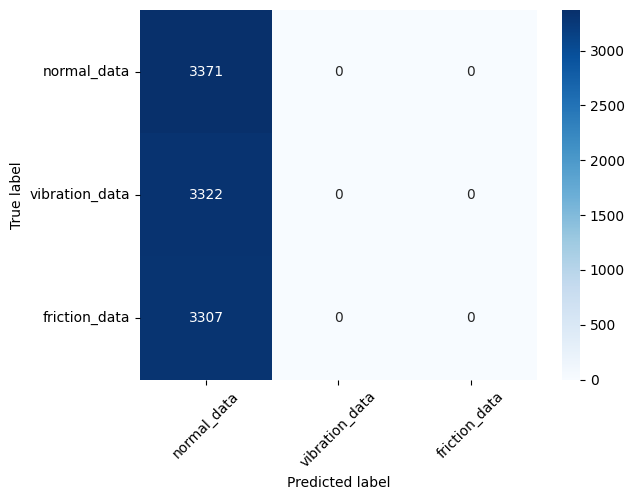

In [43]:


show_confusion_matrix(df_cm, RESULT_PATH + "_confusion_matrix.png")

In [44]:
# Predict one sequence and time it
import time
sequence = test_seq[0][0]
start = time.time()
sequence = torch.tensor(sequence).to(device, dtype=torch.float32)
sequence = sequence.unsqueeze(dim=0)
_, output = trained_model(sequence)
end = time.time()
print(f"Prediction took {end - start:.4f} seconds")


Prediction took 0.0545 seconds


In [45]:
# Predict 200 sequences and time it
errors = 0
correct = 0

pred_times = []
for i in range(1000):
    start = time.time()
    sequence = torch.tensor(test_seq[i][0]).to(device, dtype=torch.float32)
    sequence = sequence.unsqueeze(dim=0)
    _, output = trained_model(sequence)
    prediction = torch.argmax(output, dim=1)
    predictions.append(prediction.item())
    if label_encoder.inverse_transform([test_seq[i][1]])[0] != label_encoder.inverse_transform([prediction.item()])[0]:
        errors += 1
        print(f"Error: {label_encoder.inverse_transform([test_seq[1500][1]])[0]} != {label_encoder.inverse_transform([prediction.item()])[0]}")
    else:
        correct += 1
    end = time.time()
    pred_times.append(end - start)
total_time = sum(pred_times)
highest_time = max(pred_times)
lowest_time = min(pred_times)
average_time = total_time / 200
print(f"Total time: {total_time:.4f} seconds")
print(f"Highest time: {highest_time:.4f} seconds")
print(f"Lowest time: {lowest_time:.4f} seconds")
print(f"Average time: {average_time:.4f} seconds")
print(f"Errors: {errors}")
print(f"Correct: {correct}")
print(f"Accuracy: {correct / (correct + errors) * 100:.2f}%")


Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: normal != friction
Error: norma

In [46]:
# Check the accuracy of the model


In [47]:
# Check the output
prediction = torch.argmax(output, dim=1)
predictions.append(prediction.item())
print(f"Predicted: {label_encoder.inverse_transform(prediction.cpu().numpy())[0]}")
print(f"True: {label_encoder.inverse_transform([test_seq[0][1]])[0]}")

Predicted: friction
True: vibration


In [48]:

report = classification_report(labels, predictions, target_names=DATA_SETS_F)

#save to txt file

with open(RESULT_PATH + ".txt", "w") as f:
    f.write(report)

ValueError: Found input variables with inconsistent numbers of samples: [10000, 11001]

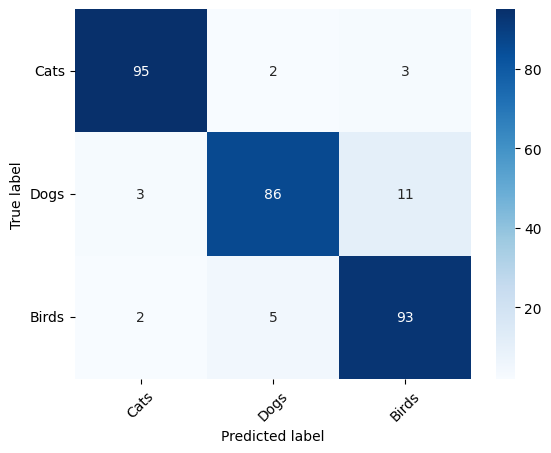

In [ ]:
# Create an illustrative confusion matrix using generic data
cm = np.array([[95, 2, 3], [3, 86, 11], [2, 5, 93]])
DATA_SETS_GENERIC = ["Cats", "Dogs", "Birds"]
df_cm = pd.DataFrame(cm, index=DATA_SETS_GENERIC, columns=DATA_SETS_GENERIC)
show_confusion_matrix(df_cm, "Results/ConfusionMatrix_Generic.png")

